In [3]:
import numpy as np
import pandas as pd
%matplotlib inline

https://github.com/bradsun91/alpha-scientist/blob/master/content/02_Feature_Engineering.ipynb

# Introduction

If you haven't yet seen the first post for this series, please take a minute to read that first... Are you back? Great. Let's enter the wormhole...

This post is going to delve into the mechanics of feature engineering for the sorts of time series data that you may use as part of a stock price prediction modeling system.

I'll cover the basic concept, then offer some useful python code recipes for transforming your raw source data into features which can be fed directly into a ML algorithm or ML pipeline.

Anyone who has dabbled with any systems-based trading or charting already has experience with simple forms of feature engineering, whether or not they realized it. For instance:

- Converting a series of asset prices into percent change values is a simple form of feature engineering
- Charting prices vs. a moving average is an implicit form of feature engineering
- Any technical indicator (RSI, MACD, etc...) are also forms of feature engineering

The process takes in one or more columns of "raw" input data (e.g., OHLC price data, 10-Q financials, social media sentiment, etc...) and converts it into many columns of engineered features.

# Motivation

I believe (and I don't think I'm alone here!) that featue engineering is the most under-appreciated part of the art of machine learning. It's certainly the most time consuming and tedious, but it's creative and "fun" (for those who like getting their hands dirty with data, anyway...).

Feature engineering is also one of the key areas where those with domain expertise can shine. Those whose expertise in investing is greater than their skill in machine learning will find that feature engineering will allow them to make use of that domain expertise.

Feature engineering is a term of art for data science and machine learning which refers to pre-processing and transforming raw data into a form which is more easily used by machine learning algorithms. Much like industrial processing can extract pure gold from trace elements within raw ore, feature engineering can extract valuable "alpha" from very noisy raw data.

You have to dig through a lot of dirt to find gold.

# Principles and guidelines

Feature engineering is fundamentally a creative process which should not be overly constrained by rules or limits.

However, I do believe there are a few guidelines to be followed:

- No peeking: Peeking (into the future) is the "original sin" of feature engineering (and prediction modeling in general). It refers to using information about the future (or information which would not yet be known by us...) to engineer a piece of data. This can be obvious, like using next_12_months_returns. However, it's most often quite subtle, like using the mean or standard deviation across the full time period to normalize data points (which implicitly leaks future information into our features. The test is whether you would be able to get the exact same value if you were calculating the data point at that point in time rather than today.


- Only the knowable: A corrolary to the above, you also need to be honest about what you would have known at the time, not just what had happened at the time. For instance, short borrowing data is reported by exchanges with a considerable time lag. You would want to stamp the feature with the date on which you would have known it.


- Complete the table: Many machine learning algorithms expect that every input feature will have a value (of a certain type) for each observation. If you envision a spreadsheet where each feature is a column and each observation is a row, there should be a value in each cell of the table. Quite often, some features in the table will naturally update themselves more frequently than others. Price data updates almost continuously, while short inventory, analyst estimates, or EBITDA tend to update every few weeks or months. In these cases, we'll use a scheme like last observation carried forward (LOCF) to always have a value for each feature in the naturally lower frequency columns. Of course, we will be careful to avoid inadvertent peeking!


- Avoid false ordinality: Finally, it's extremely important to represent features in a way that captures ordinality only if it has meaning. For instance, it's usually a bad idea to represent "day of the week" as an integer 1 to 7 since this implicitly tells the model to treat Friday as very similar to Thursday, but "a little more". It would also say that Sunday and Monday are totally different (if Sunday =7 and Monday =1). We could miss all manner of interesting patterns in the data.

# Getting Started

In [1]:
location = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/" 
j = "j9000_d.csv"
jm = "jm000_d.csv"

In [4]:
out = pd.DataFrame()

In [70]:
j_df = pd.read_csv(location+j, engine="python", header=None)
jm_df = pd.read_csv(location+jm, engine='python', header=None)
j_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings']
jm_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'holdings']

jm_df_cols = jm_df[['date', 'open', 'high', 'low', 'close', 'volume']]
j_df_cols = j_df[['date', 'open', 'high', 'low', 'close', 'volume']]

jm_df_cols['symbol'] = 'jm'
j_df_cols['symbol'] = 'j'

jm_df_cols['date'] = pd.to_datetime(jm_df_cols['date'])
j_df_cols['date'] = pd.to_datetime(j_df_cols['date'])

jm_df_cols = jm_df_cols.set_index(['date','symbol'])
j_df_cols = j_df_cols.set_index(['date', 'symbol'])

prices = pd.concat([jm_df_cols, j_df_cols]).sort_index()

In [78]:
prices.head()

,,open,high,low,close,volume
date,symbol,,,,,
2011-04-15 09:00:00,j,2275.0,2285.0,2250.0,2260.0,31834
2011-04-15 10:00:00,j,2259.0,2265.0,2252.0,2256.0,6440
2011-04-15 11:00:00,j,2256.0,2258.0,2228.0,2248.0,8264
2011-04-15 13:00:00,j,2246.0,2251.0,2238.0,2240.0,4832
2011-04-15 14:00:00,j,2241.0,2252.0,2239.0,2250.0,6710


# Creating features

Common Transforms

- Daily returns
- Today's open / previous day's close

In [79]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open-1 # daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1 
features.tail()

f01       f02
date                symbol                    
2018-12-13 11:00:00 jm      0.011583  0.000000
2018-12-13 13:00:00 j      -0.000469  0.000000
                    jm      0.002672  0.000000
2018-12-13 14:00:00 j      -0.011723  0.000235
                    jm     -0.008375  0.000000

- Logs

Many times, values like market cap, volume, revenue can map better to the prediction target if put into log space. This is easy to do via pandas+numpy:

In [80]:
features['f03'] = prices.volume.apply(np.log) # log of daily volume

- Differencing

It's often more important to know how a value is changing than to know the value itself. The diff() method will calculate the change in value since the prior period (i.e., current minus prior). NOTE: the "groupby" is critically important since if it were omitted we would be comparing the difference in volume between symbols, which is not what we want.

In [81]:
features['f03'] = prices.groupby(level='symbol').volume.diff() # change since prior day
features['f04'] = prices.groupby(level='symbol').volume.diff(50) # change since 50 days prior

- Rate of Change

Even more common is to want the rate of change as expressed by percent change. Pandas has the handy pct_change() method for this purpose, but beware that you'll get odd behavior if you mix this with groupby() as shown above. I prefer to create my own lambda wrapper function as shown below.

In [82]:
pct_chg_fxn = lambda x: x.pct_change()
features['f05'] = prices.groupby(level='symbol').volume.apply(pct_chg_fxn) 

- Moving Averages

Sometimes, we'd rather use the moving average of a value as part of a feature. This can be the value itself if you want to minimize how "jittery" a value is. Or, more commonly, you may want to compare a value with a trailing moving average of itself.

Again, we need to use groupby since our dataframe has info on multiple symbols - and again, we need to use a lambda function wrapper to avoid error. There are other patterns which will accomplish the same thing but I find this to be cleanest.

In [83]:
# log of 5 day moving average of volume
ma_5 = lambda x: x.rolling(5).mean()
features['f06'] = prices.volume.groupby(level='symbol').apply(ma_5)\
.apply(np.log) 

# daily volume vs. 200 day moving average
ma_200 = lambda x: x.rolling(200).mean()
features['f07'] = prices.volume/ prices.volume.groupby(level='symbol')\
.apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50 = lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close/ prices.close.groupby(level='symbol')\
.apply(ema_50)-1

- Z-Scores

A very popular/useful transformation for financial time series data is the z-score. We can easily define a generalized lambda function for this, which we can use whenever needed. Importantly, it allows us to mix together very different symbols (some high-beta, some low-beta) in a way that considers the statistical significance of any movement.

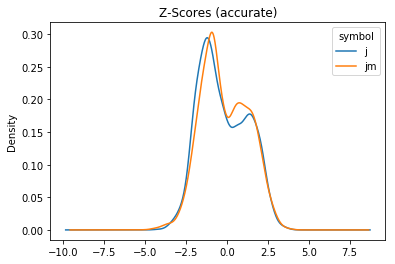

In [84]:
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())\
/ x.rolling(window=200, min_periods=20).std()
features['f10'] =prices.groupby(level='symbol').close.apply(zscore_fun_improved)
features.f10.unstack().plot.kde(title='Z-Scores (accurate)')

- Percentile

Less commonly used - but equally useful - is the percentile transformation. Getting this done properly in pandas (with groupby and rolling) is possible but tricky. The below example returns the percentile rank (from 0.00 to 1.00) of traded volume for each value as compared to a trailing 200 day period.

Note that we need to use a lambda within a lambda to make this work properly. We're on the bleeding edge.

In [85]:
rollrank_fxn = lambda x: x.rolling(200,min_periods=20)\
.apply(lambda x: pd.Series(x).rank(pct=True)[0])
features['f11'] = prices.groupby(level='symbol').volume.apply(rollrank_fxn)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


- Cross-sectional Comparison

Another interesting application of this same pattern is to rank each stock cross-sectionally rather than longitudinally as above. In other words, where does this stock rank within all of the stocks on that day, not for all prior days of that stock. The below example isn't very meaningful with only two stocks, but quite useful when using a realistic universe. In this example, we're also making use of an earlier feature (relative volume) to compare which symbol is most heavily traded for that stock's normal range in a given day. Also note that we need to dropna() prior to ranking because rank doesn't handle nulls very gracefully.

In [86]:
# Make the comparison based on the feature07
features['f12'] = features['f07'].dropna().groupby(level='date').rank(pct=True) 

In [87]:
features.head()

,,f01,f02,f03,f04,f05,f06,f07,f08,f10,f11,f12
date,symbol,,,,,,,,,,,
2011-04-15 09:00:00,j,-0.006593,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2011-04-15 10:00:00,j,-0.001328,-0.000442,-25394.0,NaN,-0.797701,NaN,NaN,-0.000868,NaN,NaN,NaN
2011-04-15 11:00:00,j,-0.003546,0.000000,1824.0,NaN,0.283230,NaN,NaN,-0.002886,NaN,NaN,NaN
2011-04-15 13:00:00,j,-0.002671,-0.000890,-3432.0,NaN,-0.415295,NaN,NaN,-0.004736,NaN,NaN,NaN
2011-04-15 14:00:00,j,0.004016,0.000446,1878.0,NaN,0.388659,9.360139,NaN,-0.000230,NaN,NaN,NaN


- Technical Indicators

In [88]:
import ta  # technical analysis library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
# money flow index (14 day)
features['f13'] = ta.momentum.money_flow_index(prices.high, 
                                               prices.low, prices.close, \
                                               prices.volume, n=14, fillna=False)
# mean-centered money flow index
features['f14'] = features['f13'] - features['f13']\
.rolling(200,min_periods=20).mean()

In [89]:
features

,,f01,f02,f03,f04,f05,f06,f07,f08,f10,f11,f12,f13,f14
date,symbol,,,,,,,,,,,,,
2011-04-15 09:00:00,j,-0.006593,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2011-04-15 10:00:00,j,-0.001328,-0.000442,-25394.0,NaN,-0.797701,NaN,NaN,-0.000868,NaN,NaN,NaN,NaN,NaN
2011-04-15 11:00:00,j,-0.003546,0.000000,1824.0,NaN,0.283230,NaN,NaN,-0.002886,NaN,NaN,NaN,NaN,NaN
2011-04-15 13:00:00,j,-0.002671,-0.000890,-3432.0,NaN,-0.415295,NaN,NaN,-0.004736,NaN,NaN,NaN,NaN,NaN
2011-04-15 14:00:00,j,0.004016,0.000446,1878.0,NaN,0.388659,9.360139,NaN,-0.000230,NaN,NaN,NaN,NaN,NaN
2011-04-18 09:00:00,j,0.041090,-0.004889,24058.0,NaN,3.585395,9.341614,NaN,0.029000,NaN,NaN,NaN,NaN,NaN
2011-04-18 10:00:00,j,0.006438,-0.000429,-530.0,NaN,-0.017226,9.690443,NaN,0.029365,NaN,NaN,NaN,NaN,NaN
2011-04-18 11:00:00,j,0.000853,0.000426,-18530.0,NaN,-0.612805,9.732177,NaN,0.026174,NaN,NaN,NaN,NaN,NaN
2011-04-18 13:00:00,j,0.013225,-0.001704,16434.0,NaN,1.403656,9.976422,NaN,0.032887,NaN,NaN,NaN,NaN,NaN


# Alternative Representations

A bit different than transforms are "representations", i.e., other ways to represent continuous values. All of the transforms above returned continuous values rather than "labels", and that's often a good place to start - especally for early prototypes.

However, you may want to represent the data in different ways, especially if using classification-based approaches or worried about the curse of dimensionality due to large numbers of features.

- Binning

We can easily convert a continous variable to discrete "bins" (like 1 to 10). This loses information, of course, but sometimes loss of information is a good thing if you are removing more noise than signal.

The below example shows volumes converted into ten equally sized buckets. In other words, we've converted a continuous variable into a discrete one.

NOTE: this example is not applied in a rolling fashion, so it does suffer from some data peeking, which I've described as the original sin. At the moment, I'm failing in my efforts to implement it in a rolling way. I'd be grateful for code snippets if anyone knows how to do this offhand.

In [90]:
n_bins = 10
bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
features['f15'] = prices.volume.groupby(level='symbol').apply(bin_fxn)

- Signing

Very simply, you may wish to convert continuous variables into positive or negative (1 or -1) values, depending on input. For instance, was volume increasing or decreasing today?

In [91]:
features['f16'] = features['f05'].apply(np.sign)

- Plus-Minus

You may be interested in how many days in a row a value has increased (or decreased). Below is a simple pattern to do just that - it calculates the number of up-days minus the number of down days.

In [92]:
plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f17'] = features['f16'].groupby(level='symbol').apply(plus_minus_fxn)

- One-Hot Encoding

Possibly the most common alternative representation is "one-hot encoding" where a categorical variable is represented as a binary. For instance, month_of_year would be represented as twelve different columns, each of which was either 0 or 1. January would be [1,0,0,0,...0] etc...

This is absolutely crucial in a few circumstances. The first is where there is false meaning in the "ordinality" of values. If we were looking to test the "santa claus effect" hypothesis, it wouldn't be helpful to use a month_of_year feature where January was "the least" and December was "the most".

The second is in cases where we are representing events or "states". Does the word "lawsuit" appear within the 10-Q footnotes? Is the company in the blackout period for share buybacks?

Finally, the particular machine learning algorithm (tree-based, neural networks) may find it easier to use binary representations than continuous or discrete ones.

The below example creates twelve one-hot features, one for each month, and names them automatically

In [93]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)
features.iloc[:,-12:].tail()

f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  \
date                symbol                                                     
2018-12-13 11:00:00 jm        0    0    0    0    0    0    0    0    0    0   
2018-12-13 13:00:00 j         0    0    0    0    0    0    0    0    0    0   
                    jm        0    0    0    0    0    0    0    0    0    0   
2018-12-13 14:00:00 j         0    0    0    0    0    0    0    0    0    0   
                    jm        0    0    0    0    0    0    0    0    0    0   

                            f28  f29  
date                symbol            
2018-12-13 11:00:00 jm        0    1  
2018-12-13 13:00:00 j         0    1  
                    jm        0    1  
2018-12-13 14:00:00 j         0    1  
                    jm        0    1

From this post, you've seen a simple code pattern for creating any number of "features" from raw input data, as well as some suggestions for useful transformations and alternative representations.

If we've done it right, this has resulted in many variations of similar features. Thus, before we start building models, we need a method of selecting only those features which provide greatest insight and robustness.

I'll cover this in the next post: https://alphascientist.com/feature_selection.html